In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import random
import matplotlib.pyplot as plt
import numpy as np

In [3]:

class VariationalEncoder(nn.Module):
    def __init__(self, image_channels, label_dim, embedding_dim, latent_dim):
        super(VariationalEncoder, self).__init__()

        self.label_embedding = nn.Embedding(label_dim, embedding_dim)

        self.conv1 = nn.Conv2d(image_channels + embedding_dim, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc21 = nn.Linear(512, latent_dim)
        self.fc22 = nn.Linear(512, latent_dim)

    def forward(self, x, labels):
        labels = self.label_embedding(labels).view(-1, 10, 1, 1).repeat(1, 1, 32, 32)
        x = torch.cat([x, labels], dim=1)

        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = h.view(h.size(0), -1)
        h = F.relu(self.fc1(h))
        mu = self.fc21(h)
        logvar = self.fc22(h)

        return mu, logvar

class VariationalDecoder(nn.Module):
    def __init__(self, latent_dim, label_dim, embedding_dim, image_channels):
        super(VariationalDecoder, self).__init__()

        self.label_embedding = nn.Embedding(label_dim, embedding_dim)

        self.fc3 = nn.Linear(latent_dim + embedding_dim, 512)
        self.fc4 = nn.Linear(512, 128 * 8 * 8)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(64, image_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, z, labels):
        labels = self.label_embedding(labels)
        z = torch.cat([z, labels], dim=1)

        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h)).view(-1, 128, 8, 8)
        h = F.relu(self.conv3(h))
        x_reconstructed = torch.sigmoid(self.conv4(h))

        return x_reconstructed

In [4]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, label_dim=10, embedding_dim=10, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = VariationalEncoder(image_channels, label_dim, embedding_dim, latent_dim)
        self.decoder = VariationalDecoder(latent_dim, label_dim, embedding_dim, image_channels)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels):
        mu, logvar = self.encoder(x, labels)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z, labels)
        return x_reconstructed, mu, logvar

# Loss function for VAE
def loss_function(reconstructed_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [5]:
# Training setup
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Lambda(lambda x: x / 2 + 0.5)  # Scale to [0, 1]
])
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 29994770.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)

optimizer = optim.Adam(vae.parameters(), lr=1e-3)
num_epochs = 50

# Training loop
vae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        reconstructed_batch, mu, logvar = vae(data, labels)
        loss = loss_function(reconstructed_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset)}")

Epoch 1, Loss: 1925.74992125
Epoch 2, Loss: 1865.578195
Epoch 3, Loss: 1856.4873315625
Epoch 4, Loss: 1846.6020271875
Epoch 5, Loss: 1842.5784159375
Epoch 6, Loss: 1840.6331828125
Epoch 7, Loss: 1838.729826875
Epoch 8, Loss: 1837.637248125
Epoch 9, Loss: 1835.7883621875
Epoch 10, Loss: 1834.0472675
Epoch 11, Loss: 1832.791919375
Epoch 12, Loss: 1831.0259184375
Epoch 13, Loss: 1830.008688125
Epoch 14, Loss: 1829.2021003125
Epoch 15, Loss: 1828.6082678125
Epoch 16, Loss: 1828.0436121875
Epoch 17, Loss: 1827.476055
Epoch 18, Loss: 1827.1051678125
Epoch 19, Loss: 1826.2241884375
Epoch 20, Loss: 1825.7793253125
Epoch 21, Loss: 1825.2023084375
Epoch 22, Loss: 1824.840976875
Epoch 23, Loss: 1824.38590625
Epoch 24, Loss: 1823.7797334375
Epoch 25, Loss: 1823.38438375
Epoch 26, Loss: 1822.85026
Epoch 27, Loss: 1822.3416034375
Epoch 28, Loss: 1821.956905625
Epoch 29, Loss: 1821.5995640625
Epoch 30, Loss: 1821.1530784375
Epoch 31, Loss: 1820.7732421875
Epoch 32, Loss: 1820.3587478125
Epoch 33, Los

In [14]:
torch.save(vae.state_dict(), 'vae_cifar10.pth')

Files already downloaded and verified


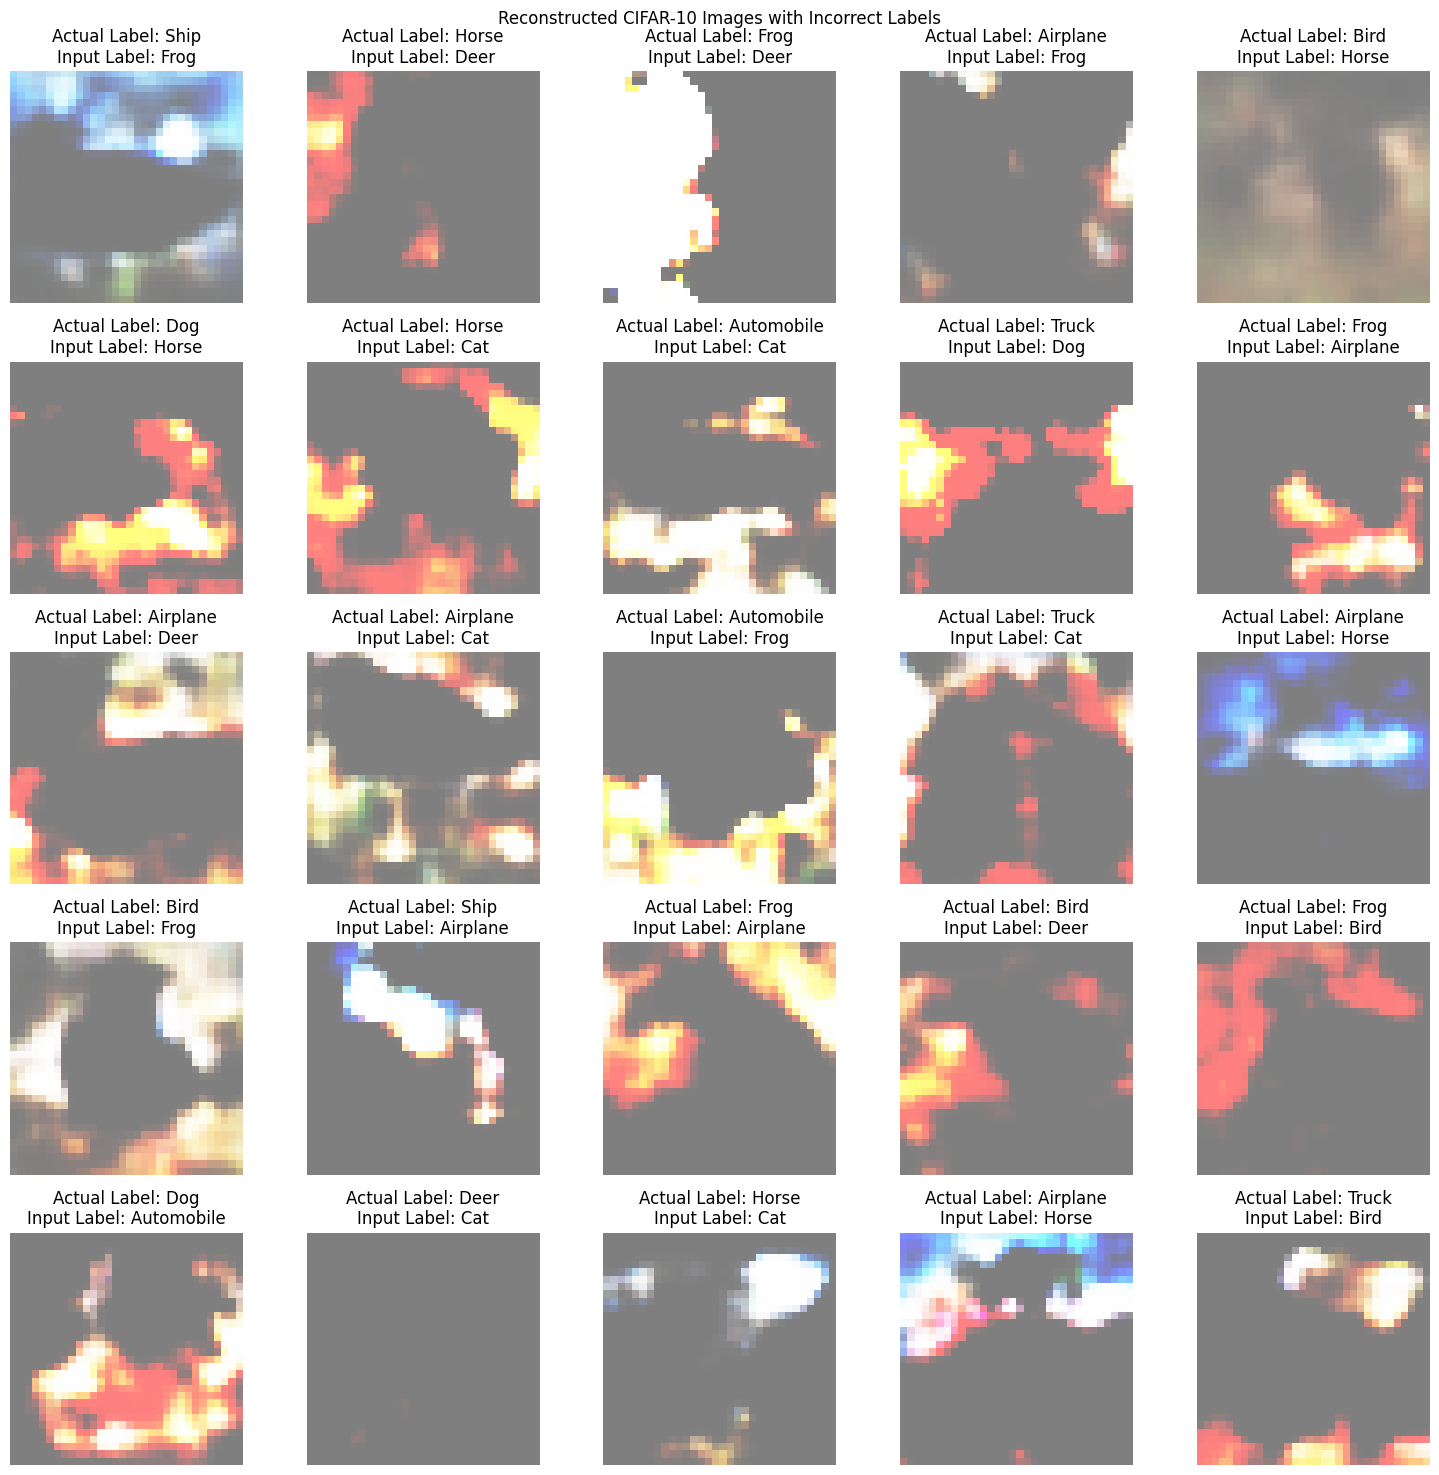

In [15]:
# CIFAR-10 class names
cifar10_classes = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck"
]

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar10_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
data_loader = DataLoader(cifar10_dataset, batch_size=25, shuffle=True)

# Function to randomly change labels
def random_swap_labels(labels):
    wrong_labels = labels.clone()
    for i in range(len(wrong_labels)):
        while True:
            wrong_label = random.randint(0, 9)
            if wrong_label != labels[i]:
                wrong_labels[i] = wrong_label
                break
    return wrong_labels

# Load VAE model (assuming it's already trained and loaded)
vae = VAE()
vae.load_state_dict(torch.load('vae_cifar10.pth'))
vae.eval()

# Get a batch of images and their correct labels
images, correct_labels = next(iter(data_loader))
wrong_labels = random_swap_labels(correct_labels)

# Pass through VAE with wrong labels
with torch.no_grad():
    reconstructed_images, _, _ = vae(images, wrong_labels)

# Prepare for visualization
images = images.numpy().transpose(0, 2, 3, 1)
reconstructed_images = reconstructed_images.numpy().transpose(0, 2, 3, 1)

fig, axs = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle("Reconstructed CIFAR-10 Images with Incorrect Labels")

for i in range(25):
    ax = axs[i // 5, i % 5]
    ax.imshow((reconstructed_images[i] * 0.5 + 0.5).clip(0, 1))  # De-normalize
    ax.set_title(f"Actual Label: {cifar10_classes[correct_labels[i].item()]}\nInput Label: {cifar10_classes[wrong_labels[i].item()]}")
    ax.axis('off')

plt.tight_layout()
plt.show()